# -----
# FIG 10 in RECCAP SO paper 
# -----
# also included: Fig. S14 and Fig. S15 (by choosing different years)
# also included: Fig. S16 (individual models)
#
# Plot trends of warming and CO2 fluxes (maps and zonal avg)
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#
# SST observations: ERSST v 5, downloaded from here (last access: Aug 25, 2023): 
# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00927
#

In [2]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

In [3]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# observations: XXX add reference XXX
path_obs = '/pscratch/sd/c/cnissen/ERSSTv5/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# script expects one of the following: 1985-2018 (Fig. 10 in main text), 1985-2000 or 2001-2018 (suppl)
year1,year2  = 1985,2018  # 1985,2000 # 2001,2018
year_string  = str(year1)+'-'+str(year2)  
year_string2 = str(year1)+'_'+str(year2)
eval_time    = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_10/'+year_string2+'/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

In [4]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
models_A = models
models_AC = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12')
versionID_models_AC    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404')
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
# NOTE: AOML is excluded from analysis further down if start year is 1985! 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630')
versionID_models_A = versionID_models
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 3 1


In [5]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [6]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [7]:
#-----
# load SST data
#-----

years_in_file = np.arange(1980,2018+1)

#-----
# models
#-----
tos_models_all = np.nan*np.ones([180,360,len(eval_time),len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'tos_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['tos'][:,:,:])
    data = annualmean(data)
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
        data = data[22:,:,:] 
    if models[ii] in ['MPIOM-HAMOCC']: # kick out 2019
        data = data[:-1,:,:]
    try: 
        data[data.mask==True]=np.nan
    except: 
        pass
    print (data.shape)
        
    # find position into which to write annual means (depends on years provided in submission)
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # these ones stop in 2017
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        if year2==2000:
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        else:
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        
    data = np.transpose(data,[1,2,0])
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        if year2==2000:
            tos_models_all[:,:,:,ii] = data[:,:,start_ind:end_ind+1]
        else:
            tos_models_all[:,:,:end_ind+1,ii] = data[:,:,start_ind:]
    else: 
        tos_models_all[:,:,:,ii] = data[:,:,start_ind:end_ind+1] #np.nanmean(data,axis=0)
    ff.close()
    del data

print ('done')


Load CCSM-WHOI
(38, 180, 360)
Load CESM-ETHZ
(39, 180, 360)
Load CNRM-ESM2-1
(39, 180, 360)
Load EC-Earth3
(39, 180, 360)
Load FESOM_REcoM_HR


/global/u2/c/cnissen/scripts_reccap/annualmean.py:43: RuntimeWarning: Mean of empty slice
  var_annualmean[t,:,:] = np.nanmean(datamB, axis=0)


(39, 180, 360)
Load FESOM_REcoM_LR
(39, 180, 360)
Load MOM6-Princeton
(39, 180, 360)
Load MPIOM-HAMOCC
(39, 180, 360)
Load MRI-ESM2-1
(39, 180, 360)
Load NorESM-OC1.2
(39, 180, 360)
Load ORCA025-GEOMAR
(39, 180, 360)
Load ORCA1-LIM3-PISCES
(39, 180, 360)
Load PlankTOM12
(39, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(39, 180, 360)
done


In [8]:
#----
# load CO2 flux data
#----

#-----
# models: simA
#-----
flux_models_simA_all = np.nan*np.ones([180,360,len(eval_time),len(models_A)])
for ii in range(0,len(models_A)):
    print ('Load simA of '+models_A[ii])
    ffA = Dataset(path_models+models_A[ii]+'_'+var+'_'+versionID_models_A[ii]+'/'+\
                    'fgco2_'+models_A[ii]+'_A_1_gr_1980-2018_'+versionID_models_A[ii]+'.nc')
    dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
    dataA = annualmean(dataA)
    if models_A[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
        dataA = -1*dataA[22:,:,:] 
    if models_A[ii] in ['MPIOM-HAMOCC']: # kick out 2019
        dataA = dataA[:-1,:,:]
    try: 
        dataA[dataA.mask==True]=np.nan
    except: 
        pass
            
    # find position into which to write annual means (depends on years provided in submission)
    if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        if year2==2000:
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        else:
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
            
    dataA = np.transpose(dataA,[1,2,0])
    if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        if year2==2000:
            flux_models_simA_all[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]
        else:
            flux_models_simA_all[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]
    else: 
        flux_models_simA_all[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]
    ffA.close()
    del dataA
        
print ('done')

#-----
# models: simC
#-----
flux_models_simC_all = np.nan*np.ones([180,360,len(eval_time),len(models_AC)])
for ii in range(0,len(models_AC)):
    print ('Load simC of '+models_AC[ii])
    ffC = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_C_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
    dataC = np.squeeze(ffC.variables['fgco2'][:,:,:])
    dataC = annualmean(dataC)
    if models_AC[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
         dataC = -1*dataC[22:,:,:] # flip sign
    if models_AC[ii] in ['MPIOM-HAMOCC']: # kick out 2019
        dataC = dataC[:-1,:,:]
    try: 
        dataC[dataC.mask==True]=np.nan
    except: 
        pass
        
    # find position into which to write annual means (depends on years provided in submission)
    if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        if year2==2000:
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        else:
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        
    dataC = np.transpose(dataC,[1,2,0])
    if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        if year2==2000:
            flux_models_simC_all[:,:,:,ii] = dataC[:,:,start_ind:end_ind+1]
        else:
            flux_models_simC_all[:,:,:end_ind+1,ii] = dataC[:,:,start_ind:]
    else: 
        flux_models_simC_all[:,:,:,ii] = dataC[:,:,start_ind:end_ind+1]
    ffC.close()
    del dataC

print ('done')


Load simA of CCSM-WHOI
Load simA of CESM-ETHZ
Load simA of CNRM-ESM2-1
Load simA of EC-Earth3
Load simA of FESOM_REcoM_HR
Load simA of FESOM_REcoM_LR
Load simA of MOM6-Princeton
Load simA of MPIOM-HAMOCC
Load simA of MRI-ESM2-1
Load simA of NorESM-OC1.2
Load simA of ORCA025-GEOMAR
Load simA of ORCA1-LIM3-PISCES
Load simA of PlankTOM12
Load simA of ROMS-SouthernOcean-ETHZ
done
Load simC of CCSM-WHOI
Load simC of CESM-ETHZ
Load simC of CNRM-ESM2-1
Load simC of EC-Earth3
Load simC of FESOM_REcoM_LR
Load simC of MPIOM-HAMOCC
Load simC of MRI-ESM2-1
Load simC of NorESM-OC1.2
Load simC of ORCA025-GEOMAR
Load simC of ORCA1-LIM3-PISCES
Load simC of PlankTOM12
done


In [9]:
#-----
# data products
#-----

if year1==1985: 
    # in this case, exclude AOML!
    print('Exclude AOML for start year',year1)
    ind_start = 1
    num_data = len(data_prod)-1
else:
    # for the later period, include AOML
    print('Include AOML for start year',year1)
    ind_start = 0
    num_data = len(data_prod)

flux_data_products_all = np.nan*np.ones([180,360,len(eval_time),num_data])
counter=0
for ii in range(ind_start,len(data_prod)):
    print ('Load '+data_prod[ii])
    ff = Dataset(path_data+data_prod[ii]+'_'+versionID_data_prod[ii]+'/'+\
                    filename_data_prod[ii])
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
            
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # get starting time of this product 
        # -> to get rid of incomplete year in beginning
        time = np.squeeze(ff.variables['time'][:])
        from datetime import date, timedelta
        day = time[0]
        start = date(1980,1,1)      # This is the "days since" part
        delta = timedelta(day)     # Create a time delta object from the number of days
        offset = start + delta      # Add the specified number of days to 1990
        print(offset)               # >>>  2015-12-01
        del time,day,start,delta,offset
        # delete first 4 entries!
        data = data[4:,:,:]
        #data = data[:-24,:,:] # kick out 2019 & 2020
            
    if data_prod[ii] in ['NIES-ML3']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
    if data_prod[ii] in ['SOMFFN']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[3*12:,:,:] # kick out 1982-1984
    if data_prod[ii] in ['JMAMLR','NIES-ML3']: 
        data = data[5*12:,:,:] # kick out 1980-1984 (filename suggests it starts in 1985, but timedim suggests otherwise)
    if data_prod[ii] in ['JMAMLR','NIES-nn','CSIRML6','SOMFFN']: # 1985-2019
        data = data[:-12,:,:] # kick out 2019
    if data_prod[ii] in ['NIES-ML3']: # 1985-2020
        data = data[:-24,:,:] # kick out 2019 & 2020
    if data_prod[ii] in ['NIES-nn','NIES-ML3']: # mask missing values
        data[data<-9999999]=np.nan
        
    data = annualmean(data)
    print (data.shape)
    data = np.transpose(data,[1,2,0]) # time is last
        
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: #1997-2020 in file, but 280 months -> 2020 not complete? 
        # it is 1998-2020
        data = data[:,:,:-2] # kick out 2019 & 2020
        years_in_file2 = np.arange(1998,2018+1)
        start_ind = np.where(years_in_file2==np.asarray(eval_time)[0])[0][0]
        flux_data_products_all[:,:,:,counter] = data[:,:,start_ind:]
        #start_ind = np.where(np.asarray(eval_time)==years_in_file2[0])[0][0]
        #flux_data_products_all[:,:,start_ind:,counter] = data
        del years_in_file2,start_ind
    else: 
        if year2==2000:
            print(data.shape)
            flux_data_products_all[:,:,:,counter] = data[:,:,0:16] # assumes that years 1985-2000 are in file
        else:
            if (year1==2001) & (year2==2018):
                flux_data_products_all[:,:,:,counter] = data[:,:,16:] # assumes the "data" is 1985-2018 at this point
            else:
                flux_data_products_all[:,:,:,counter] = data
            
    # for some products, change sign so that pos=into ocean
    if data_prod[ii] in ['NIES-nn']:
        print ('Change sign')
        flux_data_products_all[:,:,:,counter] = -1*flux_data_products_all[:,:,:,counter] 
       
    ff.close()
    del data
    counter = counter+1



Exclude AOML for start year 1985
Load CMEMS-LSCE-FFNN
(34, 180, 360)
Load CSIRML6
(34, 180, 360)
Load JenaMLS
(34, 180, 360)
Load JMAMLR
(34, 180, 360)
Load LDEO-HPD
(34, 180, 360)
Load NIES-ML3


/tmp/ipykernel_2153260/2460292.py:22: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  data = np.squeeze(ff.variables['fgco2'][:,:,:])


(34, 180, 360)
Load OceanSODAETHZ
(34, 180, 360)
Load SOMFFN
(34, 180, 360)


In [10]:
#---
# print some numbers
#---

for ii in range(0,len(models)):
    print (models[ii]+': '+str(np.nanmin(tos_models_all[:,:,:,ii]))+' '+str(np.nanmax(tos_models_all[:,:,:,ii])))


CCSM-WHOI: -2.0443453788757324 32.79911422729492
CESM-ETHZ: -1.7978453636169434 30.574647903442383
CNRM-ESM2-1: -1.8499733209609985 31.724924087524414
EC-Earth3: -1.9040731191635132 30.761369705200195
FESOM_REcoM_HR: -1.94558621058387 30.769149901136018
FESOM_REcoM_LR: -1.9285273993257765 30.340733925751294
MOM6-Princeton: -2.1196229763503927 30.708766258436967
MPIOM-HAMOCC: -1.899987816810608 31.054426193237305
MRI-ESM2-1: -1.8041852712631226 30.5380916595459
NorESM-OC1.2: -1.80044686794281 32.45627212524414
ORCA025-GEOMAR: -1.8761181831132456 31.294253102717338
ORCA1-LIM3-PISCES: -1.9215177297592163 30.990005493164062
PlankTOM12: -1.8617677688598633 33.06257629394531
ROMS-SouthernOcean-ETHZ: -1.8382500410079956 26.0299072265625


In [11]:
#----
# Avg over chosen years
#----

print (flux_models_simA_all.shape,flux_models_simC_all.shape,flux_data_products_all.shape)

if year_string in ['1985-2000']:
    ind = np.where(eval_time<=2000)[0]
    print (eval_time[ind])
    flux_models_simA   = flux_models_simA_all[:,:,ind,:]
    flux_models_simC   = flux_models_simC_all[:,:,ind,:]
    flux_data_products = flux_data_products_all[:,:,ind,:]
    tos_models         = tos_models_all[:,:,ind,:]
elif year_string in ['2001-2018']:
    ind = np.where(eval_time>2000)[0]
    print (eval_time[ind])
    flux_models_simA   = flux_models_simA_all[:,:,ind,:]
    flux_models_simC   = flux_models_simC_all[:,:,ind,:]
    flux_data_products = flux_data_products_all[:,:,ind,:]
    tos_models         = tos_models_all[:,:,ind,:]
elif year_string in ['1985-2018']:
    ind = np.where(eval_time<=2018)[0]
    print (eval_time[ind])
    flux_models_simA   = flux_models_simA_all
    flux_models_simC   = flux_models_simC_all
    flux_data_products = flux_data_products_all
    tos_models         = tos_models_all
    
print (flux_models_simA_all.shape,flux_models_simC_all.shape,flux_data_products_all.shape)


(180, 360, 34, 14) (180, 360, 34, 11) (180, 360, 34, 8)
[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018]
(180, 360, 34, 14) (180, 360, 34, 11) (180, 360, 34, 8)


In [12]:
#------
# get decadal warming trend at each location 
#------
# at each grid cell, fit linear regression

x = np.array(np.arange(0,len(eval_time[ind]))).reshape((-1, 1))
num_lon_reccap = 360
num_lat_reccap = 180

temp_trend_models = np.nan*np.ones([num_lon_reccap,num_lat_reccap,len(models)])
for pp in range(0,len(models)):
    print ('Process '+models[pp])
    for nn in range(0,num_lon_reccap):
        for mm in range(0,num_lat_reccap):
            a1 = np.array(tos_models[mm,nn,:,pp]) #.reshape((-1, 1))
            #print a1
            # kick out NaNs
            ind_noNaN = np.where(~np.isnan(a1))[0]
            a1 = a1[ind_noNaN]
            x1 = x[ind_noNaN]           
               
            try:  # only works if no NaN in time series
                model = LinearRegression()
                model.fit(x1, a1)
                if models[pp] in ['CCSM-WHOI']:
                    model = LinearRegression().fit(x[:-1], a1) 
                else:
                    model = LinearRegression().fit(x, a1)
                temp_trend_models[nn,mm,pp] = 10*model.coef_ # convert to decadal trend
            except: 
                pass
            del a1,x1
                
print ('Min/Max:',np.nanmin(temp_trend_models),np.nanmax(temp_trend_models))
print ('done')
#(34, 1) (34,)


Process CCSM-WHOI
Process CESM-ETHZ
Process CNRM-ESM2-1
Process EC-Earth3
Process FESOM_REcoM_HR
Process FESOM_REcoM_LR
Process MOM6-Princeton
Process MPIOM-HAMOCC
Process MRI-ESM2-1
Process NorESM-OC1.2
Process ORCA025-GEOMAR
Process ORCA1-LIM3-PISCES
Process PlankTOM12
Process ROMS-SouthernOcean-ETHZ
Min/Max: -1.925905160634366 2.1576641059450012
done


In [13]:
#------
# get decadal CO2 trend at each location, data products
#------
# at each grid cell, fit linear regression
num_lon_reccap = 360
num_lat_reccap = 180

x = np.array(np.arange(0,len(eval_time[ind]))).reshape((-1, 1))

co2_trend_data_products = np.nan*np.ones([num_lon_reccap,num_lat_reccap,num_data])
counter = 0
for pp in range(ind_start,len(data_prod)):
    print ('Process '+data_prod[pp])
    for nn in range(0,num_lon_reccap):
        for mm in range(0,num_lat_reccap):
            a1 = np.array(flux_data_products[mm,nn,:,counter]) #.reshape((-1, 1))
            #print a1
            # kick out NaNs
            ind_noNaN = np.where(~np.isnan(a1))[0]
            a1 = a1[ind_noNaN]
            
            # for JMAMLR, at high lats, the number of available years depends on the location! 
            if data_prod[pp] in ['JMAMLR']:
                x = np.array(np.arange(0,len(a1))).reshape((-1, 1))
                x1 = x
            else:
                x = np.array(np.arange(0,len(eval_time[ind]))).reshape((-1, 1))
                x1 = x[ind_noNaN]
                
            if a1.shape[0]>1: # requirement that at least XX of the 34 years have to be available
                # this was added in the attempt to make the maps for AOML & JMAMLR look better at high lats
                # for now, I have taken these two products out
                try:  # only works if no NaN in time series
                    model = LinearRegression()
                    model.fit(x1, a1)
                    if data_prod[pp] in ['AOML_EXTRAT']: # only available from 1998 onwards
                        model = LinearRegression().fit(x[13:], a1) 
                    else:
                        model = LinearRegression().fit(x, a1)
                    co2_trend_data_products[nn,mm,counter] = 10*model.coef_ # convert to decadal trend
                except: 
                    pass
          #  del a1,x1
    counter = counter+1

print ('Min/Max:',np.nanmin(co2_trend_data_products),np.nanmax(co2_trend_data_products))
print ('done')


Process CMEMS-LSCE-FFNN
Process CSIRML6
Process JenaMLS
Process JMAMLR
Process LDEO-HPD
Process NIES-ML3
Process OceanSODAETHZ
Process SOMFFN
Min/Max: -7.961156622826591e-07 1.0687124074593153e-06
done


In [14]:
#------
# get decadal CO2 trend at each location: simA
#------
# at each grid cell, fit linear regression

x = np.array(np.arange(0,len(eval_time[ind]))).reshape((-1, 1))
num_lon_reccap = 360
num_lat_reccap = 180

co2_trend_models_simA = np.nan*np.ones([num_lon_reccap,num_lat_reccap,len(models_A)])
for pp in range(0,len(models_A)):
    print ('Process '+models_A[pp])
    for nn in range(0,num_lon_reccap):
        for mm in range(0,num_lat_reccap):
            a1 = np.array(flux_models_simA[mm,nn,:,pp]) #.reshape((-1, 1))
            # kick out NaNs
            ind_noNaN = np.where(~np.isnan(a1))[0]
            a1 = a1[ind_noNaN]
            x1 = x[ind_noNaN]
            
            try:  # only works if no NaN in time series
                model = LinearRegression()
                model.fit(x1, a1)
                if models_A[pp] in ['CCSM-WHOI']:
                    model = LinearRegression().fit(x[:-1], a1) 
                else:
                    model = LinearRegression().fit(x, a1)
                co2_trend_models_simA[nn,mm,pp] = 10*model.coef_ # convert to decadal trend
            except: 
                pass
            del a1,x1
                
print ('Min/Max:',np.nanmin(co2_trend_models_simA),np.nanmax(co2_trend_models_simA))
print ('done')



Process CCSM-WHOI
Process CESM-ETHZ
Process CNRM-ESM2-1
Process EC-Earth3
Process FESOM_REcoM_HR
Process FESOM_REcoM_LR
Process MOM6-Princeton
Process MPIOM-HAMOCC
Process MRI-ESM2-1
Process NorESM-OC1.2
Process ORCA025-GEOMAR
Process ORCA1-LIM3-PISCES
Process PlankTOM12
Process ROMS-SouthernOcean-ETHZ
Min/Max: -1.1376355015418217e-07 6.85968462469557e-08
done


In [15]:
#------
# get decadal CO2 trend at each location: simC
#------
# at each grid cell, fit linear regression

co2_trend_models_simC = np.nan*np.ones([num_lon_reccap,num_lat_reccap,len(models_AC)])
for pp in range(0,len(models_AC)):
    print ('Process '+models_AC[pp])
    for nn in range(0,num_lon_reccap):
        for mm in range(0,num_lat_reccap):
            a1 = np.array(flux_models_simC[mm,nn,:,pp]) #.reshape((-1, 1))
            # kick out NaNs
            ind_noNaN = np.where(~np.isnan(a1))[0]
            a1 = a1[ind_noNaN]
            x1 = x[ind_noNaN]
            
            try:  # only works if no NaN in time series
                model = LinearRegression()
                model.fit(x1, a1)
                if models_AC[pp] in ['CCSM-WHOI']:
                    model = LinearRegression().fit(x[:-1], a1) 
                else:
                    model = LinearRegression().fit(x, a1)
                co2_trend_models_simC[nn,mm,pp] = 10*model.coef_ # convert to decadal trend
            except: 
                pass
            del a1,x1
             
print ('Min/Max:',np.nanmin(co2_trend_models_simC),np.nanmax(co2_trend_models_simC))
print ('done')


Process CCSM-WHOI
Process CESM-ETHZ
Process CNRM-ESM2-1
Process EC-Earth3
Process FESOM_REcoM_LR
Process MPIOM-HAMOCC
Process MRI-ESM2-1
Process NorESM-OC1.2
Process ORCA025-GEOMAR
Process ORCA1-LIM3-PISCES
Process PlankTOM12
Min/Max: -1.515396065744285e-08 2.7949105247183962e-08
done


In [16]:
#---
# plotting
#---


[1.0 2.0 3.0 --]
-179.5 180.5


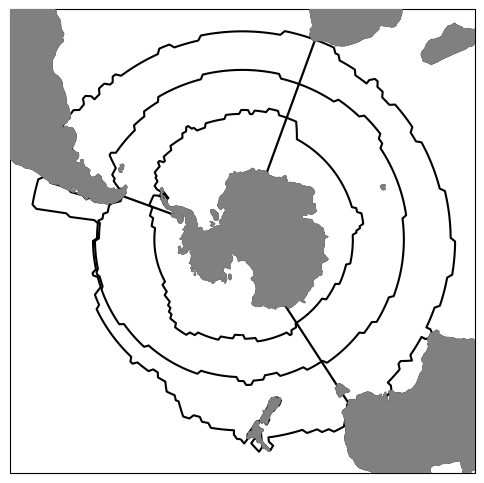

In [17]:
#-----
# test plot for contour lines of biomes
#-------

# lat/lon on RECCAP mesh
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# lon,lat for plotting
xax_X = transform_lon_coord(lon)
xax_X[xax_X>180] = xax_X[xax_X>180]-360 # lon now runs from -179.5:179.5
X, Y  = np.meshgrid(xax_X, lat) 
X = add_cyclic_point(X)
X[:,-1] = 180.5 # -> cannot be -179.5 or the plot will look weird
Y = add_cyclic_point(Y)
    
r_mask = np.copy(regions)
r_mask = transform_lon_coord(regions) 
r_mask = np.ma.masked_where(np.isnan(r_mask),r_mask)
# repeat first element at the end to get rid of grey line in plot
b = np.zeros((180,360+1))
b[:,:-1] = r_mask
b[:,-1] = r_mask[:,0]
r_mask = b

# create the corresponding mask with only 3 regions
r_mask2 = np.zeros_like(r_mask)
r_mask2[r_mask==0]=1
r_mask2[r_mask==3]=1
r_mask2[r_mask==6]=1
r_mask2[r_mask==1]=2
r_mask2[r_mask==4]=2
r_mask2[r_mask==7]=2
r_mask2[r_mask==2]=3
r_mask2[r_mask==5]=3
r_mask2[r_mask==8]=3
r_mask2 = np.ma.masked_where(r_mask2==0,r_mask2)
print(np.unique(r_mask2))
print(np.min(X),np.max(X))

# correct contour lines near Antarctica (don't want it plotted)
r_mask3 = np.copy(r_mask2)
r_mask3[0:23,:]=np.nan
r_mask3[0:26,200:340]=np.nan
r_mask3 = np.ma.masked_where(np.isnan(r_mask3),r_mask3)

#---
# on a map
#---
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()
ax.set_extent([-180,180, -90, -30],ccrs.PlateCarree())

lw = 1.5
cnt=plt.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())

plot_lon_lines = True
if plot_lon_lines:
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())

ax.add_feature(cartopy.feature.LAND,color='grey',zorder=50)
plt.show()


In [18]:
#----
# FUNCTIONS
#----

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(data_input)
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    return data_plot
    
#def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,lineslonlat,xlin,ylin):
#    color_no_SO = 'gainsboro'
#    map = Basemap(projection='spstere',boundinglat=-30,lon_0=-180,resolution='l',ax=ax)
#    x, y = map(X,Y)
#    #mm=ax.contourf(x, y, data_plot, levels=levels, cmap=colormap, extend='both') 
#    mm=ax.pcolor(x, y, data_plot,vmin=np.min(levels),vmax=np.max(levels),cmap=colormap)
#    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
#    cbar.cmap.set_under(color_no_SO)# color_continents)
#    cbar.remove()
#    fig.canvas.draw_idle() #plt.draw() does not work
#    for lin in range(len(lineslonlat)): # Plot biome boundaries from file with lines:
#        ax.plot(xlin[lin],ylin[lin], color='black', linestyle='-',linewidth=0.1,zorder=1)
#    #map.drawmapboundary(fill_color=color_continents,zorder=30) 
#    map.fillcontinents(color=color_continents,lake_color=color_continents)
#    return mm
    
    
def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015,0.94), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    #ax.annotate(plot_title1, xy=(0.095,0.94), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.089
    #ax.annotate(plot_title2, xy=(0.01,0.025), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    ax.annotate(panel_label+'  ', xy=(0.015,1.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props)
    ax.annotate(plot_title1, xy=(0.1,1.03), xycoords='axes fraction',color=color_text,\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props) # 0.089
    ax.annotate(plot_title2, xy=(0.025,0.035), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    

/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


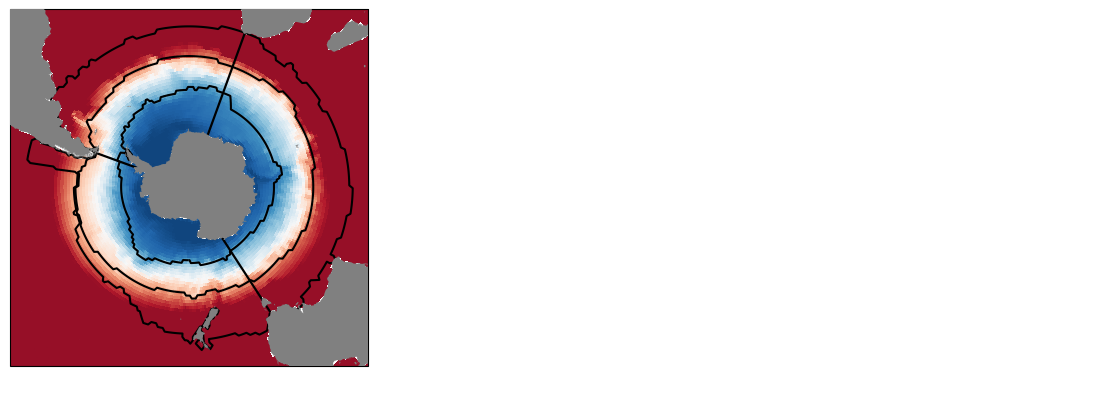

In [19]:
#-----
# test plot
#-----

color_continents = 'grey'
color_no_SO = 'gainsboro'
import copy
colormap = copy.copy(plt.cm.RdBu_r)

plot_test = True
if plot_test:

    ii = 1
    
    # data to plot
    data_plot = np.copy(tos_models[:,:,0,4])
    #print flux_models.shape
    #print models[3]
    #data_plot = np.copy(-1*factor*flux_models[:,:,3])
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    levels      = np.arange(-2,12+1,1)
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    
    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025)
    
    ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    ax=ax1
    mm=ax.pcolormesh(X,Y, data_plot,vmin=-2.5,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())#, levels=levels_test, cmap=cm.Spectral_r, extend='both') 
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_under(color_no_SO)#color_continents)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    
    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax1.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    ax1.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax1.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax1.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    
  #  plot_title2a = '1985-2018' # years
  # panel_label_a = 'a)'
  #  plot_title1a = models[ii]
  #  add_annotations_to_plot(ax1,plot_title1a,plot_title2a,panel_label_a,13,color_models)
    
    ax=ax2
    ax.set_axis_off()
    ax=ax3
    ax.set_axis_off()
    
    plt.show()



In [20]:
#-----
# ERSSTv5
#-----
# monthly values downloaded from here: 
# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00927
# merged into a single file using "cdo mergetime *nc merged_file.nc"
#
# bash script to download the data: 
# #/bin/sh
# # download ersst data from
# ersst_url=https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf
# #start year and end year to download
# yr_start=1985
# yr_end=2018
#
# for iy in $(seq $yr_start $yr_end)
# do
#   for im in {01..12}
#   do
#      echo "downloading data for $iy $im"
#      wget -q -nc -nd -P. -nv ${ersst_url}/ersst.v5.$iy$im.nc
#   done
# done

obs_annual = np.zeros([len(eval_time),12,89,180])
counter = 0
for yy in range(year1,year2+1):
    #print(yy)
    for mm in range(0,12):
        if mm+1<10:
            mm_s = '0'+str(mm+1)
        else:
            mm_s = str(mm+1)
        file1 = path_obs+'ersst.v5.'+str(yy)+mm_s+'.nc'
        ff1 = Dataset(file1)
        obs_annual[counter,mm,:,:] = np.squeeze(ff1.variables['sst'][:])
        if (counter==0) & (mm==0):
            lat_obs = ff1.variables['lat'][:]
            lon_obs = ff1.variables['lon'][:]
        ff1.close()
    counter = counter+1
# annual mean
obs_annual = np.nanmean(obs_annual,axis=1)
# mask
obs_annual[obs_annual==0] = np.nan

old_code = False
if old_code:
    # load obs
    ff = Dataset(file_obs)

    # in file: 1985-2018, i.e., 34 years * 12 months = 408 time entries
    ind_start = 0  
    ind_end   = 0 + 34*12  
    ind_time = np.arange(ind_start,ind_end)

    obs = np.squeeze(ff.variables['sst'][:]) 
    lat_obs = ff.variables['lat'][:]
    lon_obs = ff.variables['lon'][:]
    ff.close()

    obs = obs[ind_time,:,:]
    obs_annual = annualmean(obs)

    if year_string in ['1985-2000']:
        ind = np.where(eval_time<=2000)[0]
        print (eval_time[ind])
        obs_annual   = obs_annual[ind,:,:] # time is first dimension
    elif year_string in ['2001-2018']:
        ind = np.where(eval_time>2000)[0]
        print (eval_time[ind])
        obs_annual   = obs_annual[ind,:,:]
    elif year_string in ['1985-2018']:
        ind = np.where(eval_time<=2018)[0]
        print (eval_time[ind])
    
    print (obs.shape)
print (obs_annual.shape)
print (lat_obs.shape,lon_obs.shape)


(34, 89, 180)
(89,) (180,)


In [21]:
#------
# get warming trend in obs
#------
# at each grid cell, fit linear regression

x = np.array(np.arange(0,len(eval_time[ind]))).reshape((-1, 1))

temp_trend_obs = np.nan*np.ones([len(lon_obs),len(lat_obs)])
for nn in range(0,len(lon_obs)):
    for mm in range(0,len(lat_obs)):
        a1 = np.array(obs_annual[:,mm,nn]) #.reshape((-1, 1))
        
        # kick out NaNs
        ind_noNaN = np.where(~np.isnan(a1))[0]
        a1 = a1[ind_noNaN]
        x1 = x[ind_noNaN]
        
        try:  # only works if no NaN in time series
            model = LinearRegression()
            model.fit(x1, a1)
            model = LinearRegression().fit(x, a1)
            temp_trend_obs[nn,mm] = 10*model.coef_ # convert to decadal trend
        except: 
            pass
        
        del model,a1,x1
print ('Min/Max decadal trend:',np.nanmin(temp_trend_obs),np.nanmax(temp_trend_obs))


Min/Max decadal trend: -0.35583694177879643 1.0740639863728807


In [22]:
#-----
# get zonal avg of obs and plot with models
#-----

western_limit_obs = 280 #-80
eastern_limit_obs = 0

northern_limit = -30
western_limit = -80
eastern_limit = 0
bins = np.arange(-90,northern_limit,0.5)

# RECCAP models: temp
temp_trend_models_zonal = np.nanmean(temp_trend_models,axis=0)

# OBS: temp
temp_trend_obs_zonal = np.nanmean(temp_trend_obs,axis=0)

# RECCAP models avg: CO2 flux
co2_trend_models_A_zonal = np.nanmean(co2_trend_models_simA,axis=0)
co2_trend_models_C_zonal = np.nanmean(co2_trend_models_simC,axis=0)

# RECCAP data products avg: CO2 flux
co2_trend_data_products_A_zonal = np.nanmean(co2_trend_data_products,axis=0)

# only include those in multi-model mean that are also available in simC

ind_list = [0,1,2,3,5,7,8,9,10,11,12]
temp_trend_models_zonal_to_avg = temp_trend_models_zonal[:,ind_list]
co2_trend_models_A_zonal_to_avg = co2_trend_models_A_zonal[:,ind_list]

print (temp_trend_models_zonal.shape,co2_trend_models_A_zonal.shape,co2_trend_models_C_zonal.shape)


(180, 14) (180, 14) (180, 11)


/tmp/ipykernel_2153260/4134072218.py:14: RuntimeWarning: Mean of empty slice
  temp_trend_models_zonal = np.nanmean(temp_trend_models,axis=0)
/tmp/ipykernel_2153260/4134072218.py:20: RuntimeWarning: Mean of empty slice
  co2_trend_models_A_zonal = np.nanmean(co2_trend_models_simA,axis=0)
/tmp/ipykernel_2153260/4134072218.py:21: RuntimeWarning: Mean of empty slice
  co2_trend_models_C_zonal = np.nanmean(co2_trend_models_simC,axis=0)
/tmp/ipykernel_2153260/4134072218.py:24: RuntimeWarning: Mean of empty slice
  co2_trend_data_products_A_zonal = np.nanmean(co2_trend_data_products,axis=0)


In [23]:
#-----
# PLOTS
#-----

In [24]:
#----
# FUNCTIONS
#----

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(data_input)
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    return data_plot
    
def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): 
    color_no_SO = 'gainsboro'
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    #mm=ax.pcolor(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    #mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    #mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=10,cmap=colormap,transform=ccrs.PlateCarree())
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_over(color_no_SO)
    cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    
    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax.contour(X,Y,r_mask,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    # add continents
    ax.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    #ax.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    return mm    
    
def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015+0.01,1.03), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text+1)#,bbox=bbox_props)
    #ax.annotate(plot_title1, xy=(0.13,1.03), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text+1)#,bbox=bbox_props)
    ax.annotate(plot_title2, xy=(0.01+0.02,0.025+0.02), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    


In [25]:
#-----
# settings for plots
#-----

#lon_obs2 = np.concatenate((lon_obs,np.full(1,lon_obs[0]))) 
#X2, Y2  = np.meshgrid(lon_obs2, lat_obs) 

dpicnt = 200
fs = 14
lw = 1.25
levels      = np.arange(-0.5,0.55,0.05)
#colormap
fs_label    = 14
fs_text     = 14
color_continents = 'grey'
label_colorbar   = 'SST trend '+year_string+' ($^{\circ}$C decade$^{-1}$)'

line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
    
color_models     = 'C2' 
color_data = 'C0' # 'black' 
save_plot = True


models...


/tmp/ipykernel_2153260/2549460057.py:41: RuntimeWarning: Mean of empty slice
  data_plot1 = np.copy(np.transpose(np.nanmean(co2_trend_models_simA[:,:,ind_list],axis=2)))


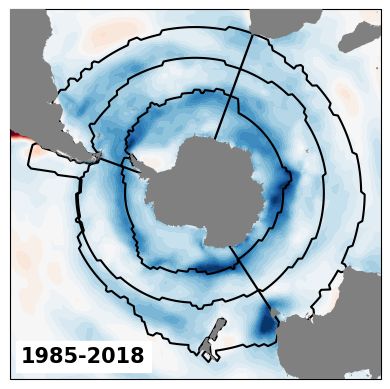

data products...


/tmp/ipykernel_2153260/2549460057.py:65: RuntimeWarning: Mean of empty slice
  data_plot1 = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))


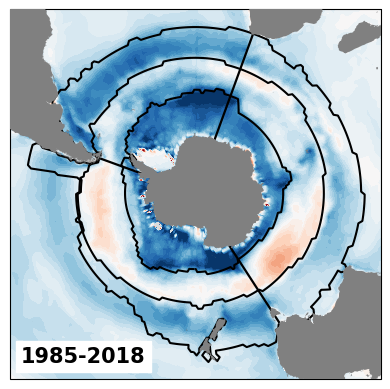

In [26]:
#-----
# MAPS: CO2 fluxes in simA and data products
#-----

if year_string in ['2001-2018','2001_2018','1985_2000','1985-2000']:
    levels      = np.arange(-0.6,0.64,0.04)
    cticks = [-0.6,-0.3,0,0.3,0.6]
else:
    levels      = np.arange(-0.35,0.37,0.02)
    cticks = [-0.3,-0.15,0,0.15,0.3]

factor = -1*86400*365

line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]

#-----
# MAP: MULTI-MODEL MEAN, simA
#-----
print('models...')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())  
ax.set_extent([-180, 180, -90, -30])
#ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#ax=ax3
#ax.set_axis_off()
#ax=ax6
#ax.set_axis_off()
#ax.set_axis_off()
data_plot1 = np.copy(np.transpose(np.nanmean(co2_trend_models_simA[:,:,ind_list],axis=2)))
data_plot = get_data_plot(data_plot1,levels)
data_plot = factor*data_plot
data_plot[data_plot<levels[0]]=levels[0]+0.01
map=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = str(year1)+'-'+str(year2)
add_annotations_to_plot(ax,'GOBMs, simulation A',plot_time_string,'',fs_text+1,color_models)
del data_plot,data_plot1,plot_time_string
if save_plot:
    plt.savefig(save_to_dir+'Maps_CO2_flux_trend_models_decadal_'+year_string2+'_only.png',\
                            dpi = dpicnt, bbox_inches='tight',format='png') 
    plt.savefig(save_to_dir+'Maps_CO2_flux_trend_models_decadal_'+year_string2+'_only.pdf',\
                            dpi = dpicnt, bbox_inches='tight',format='pdf') 
plt.show()


#-----
# MAP: data products
#-----
print('data products...')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())  
ax.set_extent([-180, 180, -90, -30])
#ax.set_axis_off()
data_plot1 = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))
data_plot = get_data_plot(data_plot1,levels)
data_plot = factor*data_plot
data_plot[data_plot<levels[0]]=levels[0]+0.01
map=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = str(year1)+'-'+str(year2)
add_annotations_to_plot(ax,'pCO$_{2}$-products',plot_time_string,'',fs_text+1,color_data)
#del data_plot,data_plot1,plot_time_string
if save_plot:
    plt.savefig(save_to_dir+'Maps_CO2_flux_trend_data_prod_decadal_'+year_string2+'_only.png',\
                            dpi = dpicnt, bbox_inches='tight',format='png') 
    plt.savefig(save_to_dir+'Maps_CO2_flux_trend_data_prod_decadal_'+year_string2+'_only.pdf',\
                            dpi = dpicnt, bbox_inches='tight',format='pdf') 
plt.show()



Separate COLORBAR...


/tmp/ipykernel_2153260/3332948340.py:25: RuntimeWarning: Mean of empty slice
  data_plot = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))


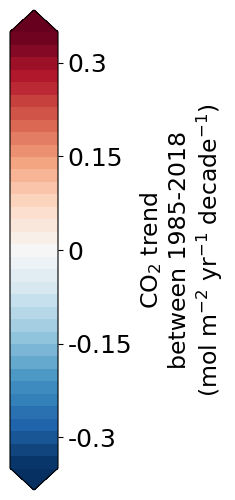

/tmp/ipykernel_2153260/3332948340.py:51: RuntimeWarning: Mean of empty slice
  data_plot = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))


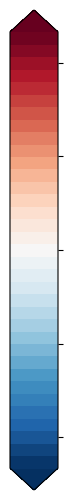

In [27]:
#-----
# COLORBAR: plot separately
#-----
print('Separate COLORBAR...')

def plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #mm=ax.pcolor(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    colormap = copy.copy(plt.cm.RdBu_r)
    mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    cbar=plt.colorbar(mm, ax=ax,orientation='vertical',shrink=0.5,pad=0.05) 
    #cbar.cmap.set_over(color_continents)
    #cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    return mm

if year_string in ['2001-2018','2001_2018','1985_2000','1985-2000']:
    cticks_label = [-0.6,-0.3,0,0.3,0.6]
else:
    cticks_label = [-0.3,-0.15,0,0.15,0.3]
    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) 
data_plot = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))
data_plot = get_data_plot(data_plot,levels)
data_plot = factor*data_plot
data_plot[data_plot<levels[0]]=levels[0]+0.01
mm=plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
fig.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.04, 0.8])
cbar=fig.colorbar(mm,cax=cax,orientation='vertical',ticks=cticks)#,fraction=0.075, shrink=1.0)#pad=0.15,cax=cbar_ax, 
cbar.set_label('CO$_{2}$ trend\nbetween '+year_string+\
               '\n(mol m$^{-2}$ yr$^{-1}$ decade$^{-1}$)',fontsize=fs_text+3)
cbar.ax.tick_params(labelsize=fs_text+4)
cbar.ax.set_yticklabels(cticks_label)
filename = 'Maps_CO2_flux_trend_decadal_'+year_string2+'_COLORBAR.png'
if save_plot: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
plt.show()


#---
# EPS
#---
cticks_label = []
plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) 
    data_plot = np.copy(np.transpose(np.nanmean(co2_trend_data_products[:,:,:],axis=2)))
    data_plot = get_data_plot(data_plot,levels)
    data_plot = factor*data_plot
    data_plot[data_plot<levels[0]]=levels[0]+0.01
    mm=plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
    fig.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.04, 0.8])
    cbar=fig.colorbar(mm,cax=cax,orientation='vertical',ticks=cticks)#,fraction=0.075, shrink=1.0)#pad=0.15,cax=cbar_ax, 
    cbar.ax.tick_params(labelsize=fs_text+4)
    cbar.ax.set_yticklabels(cticks_label)
    filename = 'Maps_CO2_flux_trend_decadal_'+year_string2+'_COLORBAR.eps'
    if save_plot: 
        plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps')     
    plt.show()


/tmp/ipykernel_2153260/2179887040.py:22: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/2179887040.py:30: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1),color=color_models,\


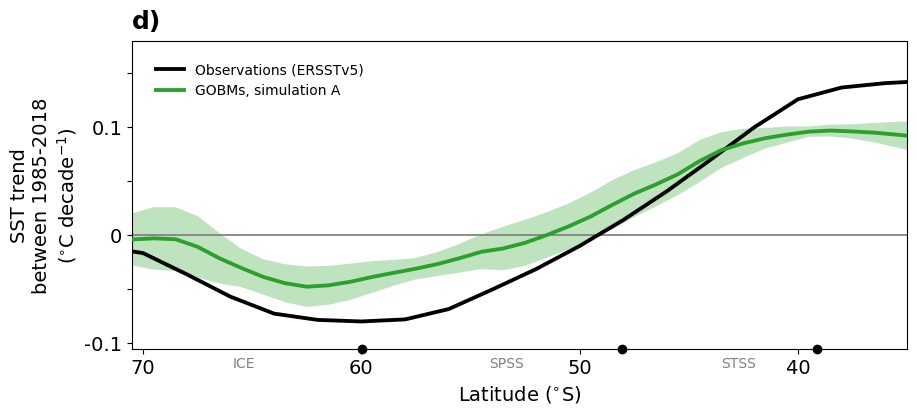

/tmp/ipykernel_2153260/2179887040.py:91: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/2179887040.py:99: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1),color=color_models,\
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


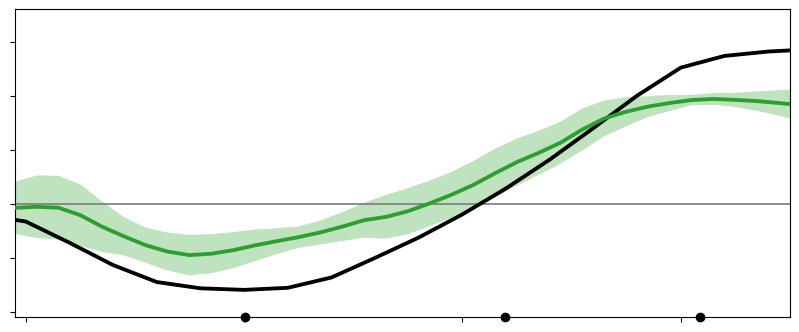

In [28]:
#-----
# zonal avg: CO2 flux in models/data products, SST in models vs obs
#-----

with_std = True # decide whether to plot std for CO2 trends
if with_std:
    std_string = '_with_std'
else:
    std_string = ''
    
lon_reccap = np.arange(0.5,359.5+1,1)
lat_reccap = np.arange(-89.5,89.5+1,1)
    
#-----
# zonal avg: temp
#-----
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1) 

ax.hlines(0,-75,30,color='grey',linestyle='-',linewidth=lw)

a1  = np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1)
a1_std = np.nanstd(temp_trend_models_zonal[:,ind_list],axis=1)
a2a = a1+a1_std
a2b = a1-a1_std
alpha_std = 0.3
ax.fill_between(lat_reccap, a2a, a2b, color=color_models,alpha = alpha_std,edgecolor='none') 

ax.plot(lat_obs,temp_trend_obs_zonal,color='black',linewidth=lw+1.5,label='Observations (ERSSTv5)',zorder=30)
ax.plot(lat_reccap,np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1),color=color_models,\
             linestyle='-',linewidth=lw+1.5,label='GOBMs, simulation A',zorder=40)

ax.set_ylabel('SST trend\nbetween '+year_string+'\n($^{\circ}$C decade$^{-1}$)',fontsize=fs)
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
ax.set_xticklabels([90,80,70,60,50,40,30]) #[90,80,70,60,50,40,30]
ax.set_xlim((-70.5,-35))
if year_string in ['2001-2018','2001_2018']:
    ylim1 = -0.2
    ax.set_ylim((ylim1,0.34))
    ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels([-0.2,'',0,'',0.2,'',0.4]) #[90,80,70,60,50,40,30]
elif year_string in ['1985-2000','1985_2000']:
    ylim1 = -0.34
    ax.set_ylim((ylim1,0.25))
    ax.set_yticks([-0.3,-0.2,-0.1,0,0.1,0.2])
    ax.set_yticklabels([-0.3,-0.2,-0.1,0,0.1,0.2]) #[90,80,70,60,50,40,30]
else:
    ylim1 = -0.105
    ax.set_ylim((ylim1,0.18))
    ax.set_yticks([-0.1,-0.05,0,0.05,0.1,0.15])
    ax.set_yticklabels([-0.1,'',0,'',0.1,'']) #[90,80,70,60,50,40,30]

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs)
        
mark_subregions = True
if mark_subregions:
    circle_size = 6
    color_marker = 'black'
    fs2 = 10
    color_text = 'grey'
    l1=plt.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=plt.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=plt.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    plt.annotate('ICE',xy=(0.13,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    plt.annotate('SPSS',xy=(0.46,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    plt.annotate('STSS',xy=(0.76,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
        
ax.legend(loc='upper center', bbox_to_anchor=(0.165, 0.97),\
               ncol=1,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 10})
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) 
ax.annotate('d)', xy=(0.0,1.04), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+4)#,bbox=bbox_props) #(0.018,0.9)
if save_plot:
    plt.savefig(save_to_dir+'Zonal_avg_SST_trend_trend_decadal_'+year_string2+'_only'+std_string+'.png',\
                            dpi = dpicnt, bbox_inches='tight',format='png') 
    plt.savefig(save_to_dir+'Zonal_avg_SST_trend_trend_decadal_'+year_string2+'_only'+std_string+'.pdf',\
                            dpi = dpicnt, bbox_inches='tight',format='pdf') 
plt.show()

plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 1, 1) 

    ax.hlines(0,-75,30,color='grey',linestyle='-',linewidth=lw)

    a1  = np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1)
    a1_std = np.nanstd(temp_trend_models_zonal[:,ind_list],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    alpha_std = 0.3
    ax.fill_between(lat_reccap, a2a, a2b, color=color_models,alpha = alpha_std,edgecolor='none') 

    ax.plot(lat_obs,temp_trend_obs_zonal,color='black',linewidth=lw+1.5,label='Observations (ERSSTv5)',zorder=30)
    ax.plot(lat_reccap,np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1),color=color_models,\
                 linestyle='-',linewidth=lw+1.5,label='GOBMs, simulation A',zorder=40)

    ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
    ax.set_xticklabels([]) #[90,80,70,60,50,40,30]
    ax.set_xlim((-70.5,-35))
    if year_string in ['2001-2018','2001_2018']:
        ylim1 = -0.2
        ax.set_ylim((ylim1,0.34))
        ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3,0.4])
        ax.set_yticklabels([]) #[90,80,70,60,50,40,30]
    elif year_string in ['1985-2000','1985_2000']:
        ylim1 = -0.34
        ax.set_ylim((ylim1,0.25))
        ax.set_yticks([-0.3,-0.2,-0.1,0,0.1,0.2])
        ax.set_yticklabels([]) #[90,80,70,60,50,40,30]
    else:
        ylim1 = -0.105
        ax.set_ylim((ylim1,0.18))
        ax.set_yticks([-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_yticklabels([]) #[90,80,70,60,50,40,30]

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs)

    mark_subregions = True
    if mark_subregions:
        circle_size = 6
        color_marker = 'black'
        fs2 = 10
        color_text = 'grey'
        l1=plt.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l2=plt.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l3=plt.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        
    if save_plot:
        plt.savefig(save_to_dir+'Zonal_avg_SST_trend_trend_decadal_'+year_string2+'_only'+std_string+'.eps',\
                                dpi = dpicnt, bbox_inches='tight',format='eps') 
    plt.show()



/tmp/ipykernel_2153260/253460739.py:7: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(factor*co2_trend_models_A_zonal_to_avg,axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/253460739.py:13: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_A_zonal_to_avg,axis=1),color=color_models,\
/tmp/ipykernel_2153260/253460739.py:17: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(factor*co2_trend_models_C_zonal,axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/253460739.py:23: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,factor*np.nanmean(co2

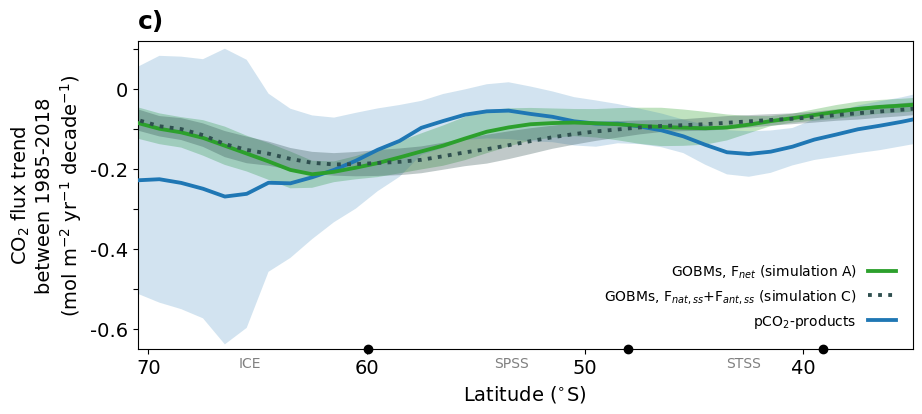

/tmp/ipykernel_2153260/253460739.py:139: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(factor*co2_trend_models_A_zonal_to_avg,axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/253460739.py:145: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_A_zonal_to_avg,axis=1),color=color_models,\
/tmp/ipykernel_2153260/253460739.py:149: RuntimeWarning: Mean of empty slice
  a1  = np.nanmean(factor*co2_trend_models_C_zonal,axis=1)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2153260/253460739.py:155: RuntimeWarning: Mean of empty slice
  ax.plot(lat_reccap,factor*np.nanmea

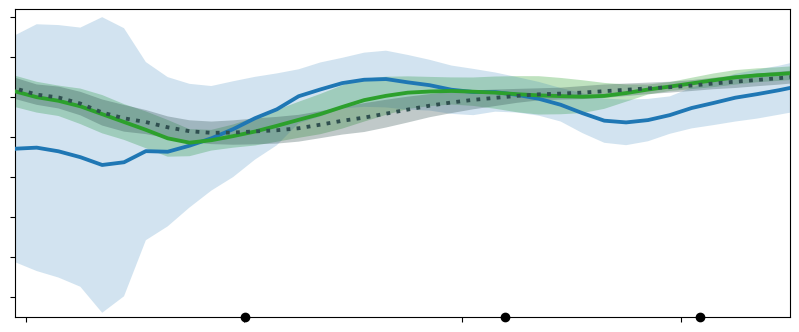

In [29]:
#-----
# zonal avg, CO2 flux, simA, simC
#-----
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1) 
if with_std:
    a1  = np.nanmean(factor*co2_trend_models_A_zonal_to_avg,axis=1)
    a1_std = np.nanstd(factor*co2_trend_models_A_zonal_to_avg,axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    alpha_std = 0.3
    ax.fill_between(lat_reccap, a2a, a2b, color=color_models,alpha = alpha_std,edgecolor='none',zorder=0) 
ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_A_zonal_to_avg,axis=1),color=color_models,\
             linestyle='-',linewidth=lw+1.5,label='GOBMs, F$_{net}$ (simulation A)',zorder=40)

if with_std:
    a1  = np.nanmean(factor*co2_trend_models_C_zonal,axis=1)
    a1_std = np.nanstd(factor*co2_trend_models_C_zonal,axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    alpha_std = 0.3
    ax.fill_between(lat_reccap, a2a, a2b, color='darkslategray',alpha = alpha_std,edgecolor='none',zorder=2) 
ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_C_zonal,axis=1),color='darkslategray',\
             linestyle=':',linewidth=lw+1.5,label='GOBMs, F$_{nat,ss}$+F$_{ant,ss}$ (simulation C)',zorder=40)

if with_std:
    a1  = np.nanmean(factor*co2_trend_data_products_A_zonal,axis=1)
    a1_std = np.nanstd(factor*co2_trend_data_products_A_zonal,axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    alpha_std = 0.3
    ax.fill_between(lat_reccap, a2a, a2b, color='C0',alpha = alpha_std-0.1,edgecolor='none',zorder=1) 
ax.plot(lat_reccap,factor*np.nanmean(co2_trend_data_products_A_zonal,axis=1),color='C0',\
             linestyle='-',linewidth=lw+1.5,label='pCO$_{2}$-products',zorder=39)
ax.set_ylabel('CO$_{2}$ flux trend\nbetween '+year_string+'\n(mol m$^{-2}$ yr$^{-1}$ decade$^{-1}$)',fontsize=fs)
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
ax.set_xticklabels([90,80,70,60,50,40,30])
ax.set_xlim((-70.5,-35))
if with_std:
    if year_string in ['2001-2018','2001_2018']:
        ylim1 = -0.65
        ax.set_ylim((ylim1,0.1))
        ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1])
        ax.set_yticklabels([-0.6,'',-0.4,'',-0.2,'',0,''])
    elif year_string in ['1985-2000','1985_2000']:
        ylim1 = -0.65
        ax.set_ylim((ylim1,0.3))
        ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
        ax.set_yticklabels([-0.6,'',-0.4,'',-0.2,'',0,'',0.2,''])
    else:
        ylim1 = -0.65
        ax.set_ylim((ylim1,0.12))
        ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1])
        ax.set_yticklabels([-0.6,'',-0.4,'',-0.2,'',0,''])
else:
    if year_string in ['2001-2018','2001_2018']:
        ylim1 = -0.4
        ax.set_ylim((ylim1,0))
        ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0])
        ax.set_yticklabels([-0.4,'',-0.2,'',0])
    elif year_string in ['1985-2000','1985_2000']:
        ylim1 = -0.25
        ax.set_ylim((ylim1,0.11))
        ax.set_yticks([-0.2,-0.1,0,0.1])
        ax.set_yticklabels([-0.2,-0.1,0,0.1])
    else:
        ylim1 = -0.28
        ax.set_ylim((ylim1,-0.01))
        ax.set_yticks([-0.25,-0.2,-0.15,-0.1,-0.05])
        ax.set_yticklabels(['',-0.2,'',-0.1,''])

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs)
        
mark_subregions = True
if mark_subregions:
    circle_size = 6
    color_marker = 'black'
    fs2 = 10
    color_text = 'grey'
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)

if year_string in ['2001-2018','2001_2018']:
    #ax.legend(loc='upper center', bbox_to_anchor=(0.43, 0.99),\
    #           ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 6}) 
    ax.legend(loc='upper center', bbox_to_anchor=(0.79, 0.32),\
               ncol=1,fancybox=True,markerfirst=False,frameon=False,shadow=False,prop={'size': 10}) 
elif year_string in ['1985-2018','1985_2018']:
    if with_std:
        #ax.legend(loc='upper center', bbox_to_anchor=(0.6, 0.15),\
        #       ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 6}) 
        ax.legend(loc='upper center', bbox_to_anchor=(0.79, 0.32),\
               ncol=1,fancybox=True,markerfirst=False,frameon=False,shadow=False,prop={'size': 10}) 
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.155, 0.99),\
               ncol=1,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 10})     
else:
    if with_std:
        #ax.legend(loc='upper center', bbox_to_anchor=(0.55, 0.15),\
        #       ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 6}) 
        ax.legend(loc='upper center', bbox_to_anchor=(0.79, 0.32),\
               ncol=1,fancybox=True,markerfirst=False,frameon=False,shadow=False,prop={'size': 10}) 
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.14, 0.99),\
               ncol=1,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 10})     
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
ax.annotate('c)', xy=(0.0,1.04), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+4)#,bbox=bbox_props) #(0.018,0.9)

if with_std:
    std_string = '_with_std'
else:
    std_string = ''
    
if save_plot:
    plt.savefig(save_to_dir+'Zonal_avg_CO2_flux_trend_decadal_'+year_string2+'_only'+std_string+'.png',\
                            dpi = dpicnt, bbox_inches='tight',format='png') 
    plt.savefig(save_to_dir+'Zonal_avg_CO2_flux_trend_decadal_'+year_string2+'_only'+std_string+'.pdf',\
                            dpi = dpicnt, bbox_inches='tight',format='pdf') 
plt.show()


#---
# EPS
#---

if plot_eps:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 1, 1) 
    if with_std:
        a1  = np.nanmean(factor*co2_trend_models_A_zonal_to_avg,axis=1)
        a1_std = np.nanstd(factor*co2_trend_models_A_zonal_to_avg,axis=1)
        a2a = a1+a1_std
        a2b = a1-a1_std
        alpha_std = 0.3
        ax.fill_between(lat_reccap, a2a, a2b, color=color_models,alpha = alpha_std,edgecolor='none',zorder=0) 
    ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_A_zonal_to_avg,axis=1),color=color_models,\
                 linestyle='-',linewidth=lw+1.5,label='GOBMs, F$_{net}$ (simulation A)',zorder=40)

    if with_std:
        a1  = np.nanmean(factor*co2_trend_models_C_zonal,axis=1)
        a1_std = np.nanstd(factor*co2_trend_models_C_zonal,axis=1)
        a2a = a1+a1_std
        a2b = a1-a1_std
        alpha_std = 0.3
        ax.fill_between(lat_reccap, a2a, a2b, color='darkslategray',alpha = alpha_std,edgecolor='none',zorder=2) 
    ax.plot(lat_reccap,factor*np.nanmean(co2_trend_models_C_zonal,axis=1),color='darkslategray',\
                 linestyle=':',linewidth=lw+1.5,label='GOBMs, F$_{nat,ss}$+F$_{ant,ss}$ (simulation C)',zorder=40)

    if with_std:
        a1  = np.nanmean(factor*co2_trend_data_products_A_zonal,axis=1)
        a1_std = np.nanstd(factor*co2_trend_data_products_A_zonal,axis=1)
        a2a = a1+a1_std
        a2b = a1-a1_std
        alpha_std = 0.3
        ax.fill_between(lat_reccap, a2a, a2b, color='C0',alpha = alpha_std-0.1,edgecolor='none',zorder=1) 
    ax.plot(lat_reccap,factor*np.nanmean(co2_trend_data_products_A_zonal,axis=1),color='C0',\
                 linestyle='-',linewidth=lw+1.5,label='pCO$_{2}$-products',zorder=39)
    ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
    ax.set_xticklabels([])
    ax.set_xlim((-70.5,-35))
    if with_std:
        if year_string in ['2001-2018','2001_2018']:
            ylim1 = -0.65
            ax.set_ylim((ylim1,0.1))
            ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1])
            ax.set_yticklabels([])
        elif year_string in ['1985-2000','1985_2000']:
            ylim1 = -0.65
            ax.set_ylim((ylim1,0.3))
            ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
            ax.set_yticklabels([])
        else:
            ylim1 = -0.65
            ax.set_ylim((ylim1,0.12))
            ax.set_yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1])
            ax.set_yticklabels([])
    else:
        if year_string in ['2001-2018','2001_2018']:
            ylim1 = -0.4
            ax.set_ylim((ylim1,0))
            ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0])
            ax.set_yticklabels([])
        elif year_string in ['1985-2000','1985_2000']:
            ylim1 = -0.25
            ax.set_ylim((ylim1,0.11))
            ax.set_yticks([-0.2,-0.1,0,0.1])
            ax.set_yticklabels([])
        else:
            ylim1 = -0.28
            ax.set_ylim((ylim1,-0.01))
            ax.set_yticks([-0.25,-0.2,-0.15,-0.1,-0.05])
            ax.set_yticklabels([])

    mark_subregions = True
    if mark_subregions:
        circle_size = 6
        color_marker = 'black'
        fs2 = 10
        color_text = 'grey'
        l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        
    if with_std:
        std_string = '_with_std'
    else:
        std_string = ''

    if save_plot:
        plt.savefig(save_to_dir+'Zonal_avg_CO2_flux_trend_decadal_'+year_string2+'_only'+std_string+'.eps',\
                                dpi = dpicnt, bbox_inches='tight',format='eps') 
    plt.show()



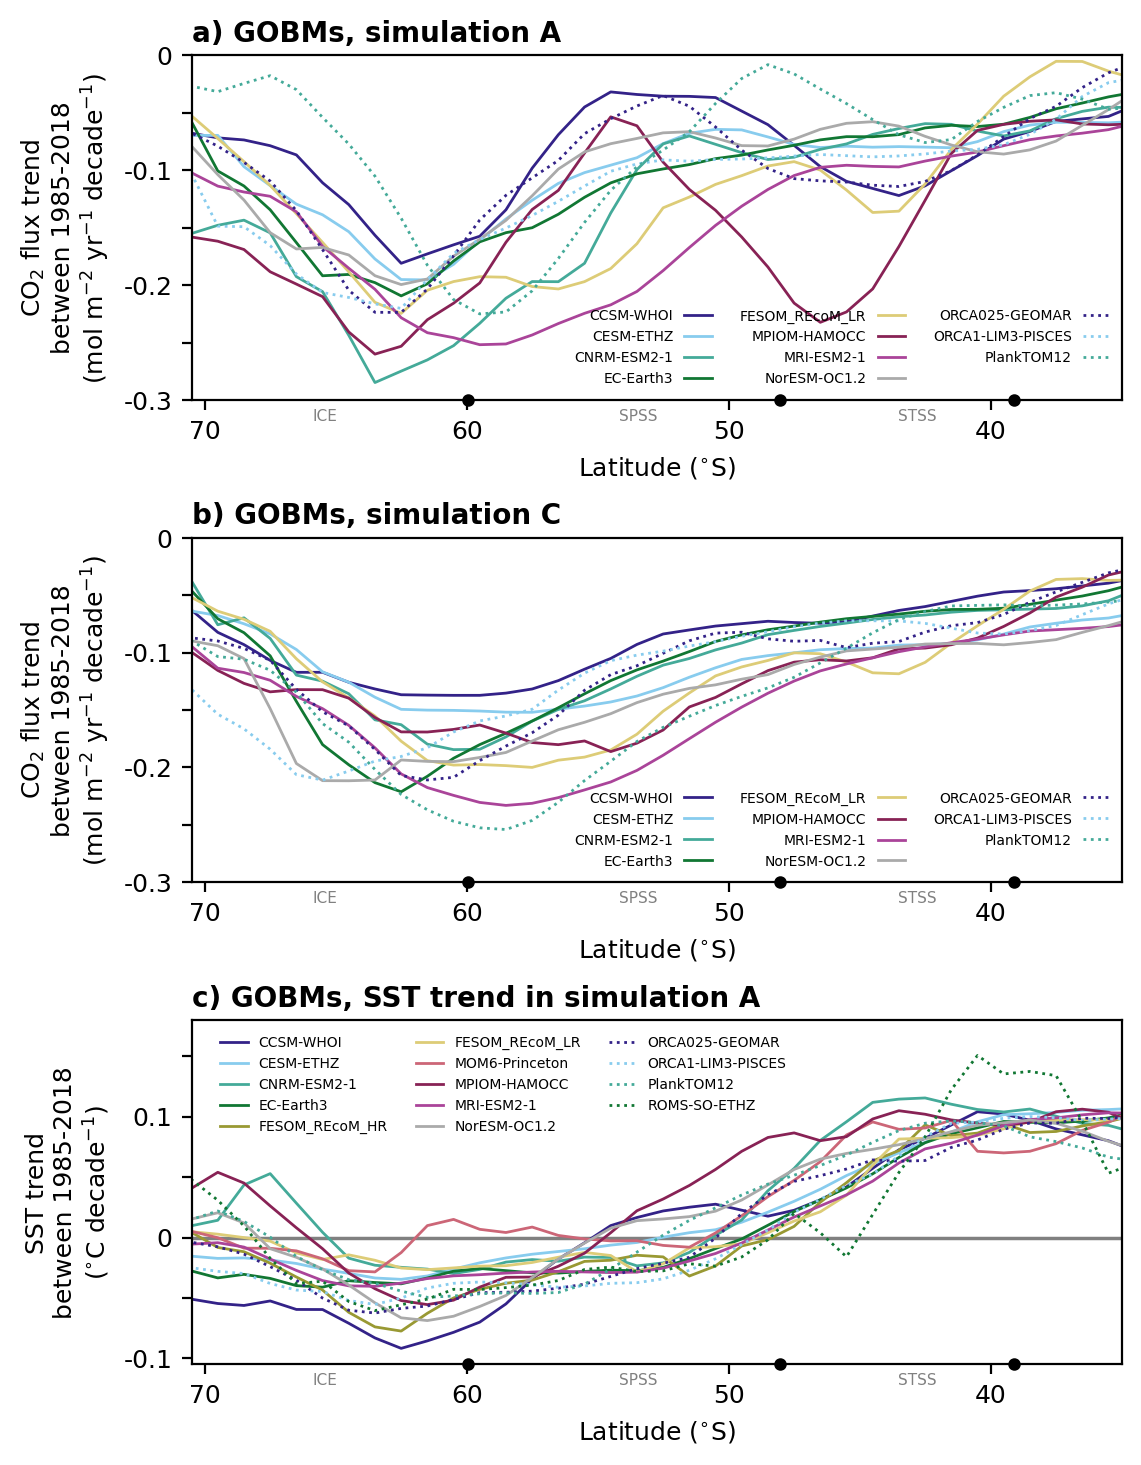

In [30]:
#-----
# zonal avg: CO2 flux in all models (simA vs simC)
# final version: add plot with individual models for SST trend
# FOR SUPPLEMENT
#-----

fig, axs = plt.subplots(3,1,figsize=(6,8.5), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],'height_ratios': [1,1,1]})
plt.subplots_adjust(wspace=0.025)
plt.subplots_adjust(hspace=0.4)
    
ax1 = plt.subplot2grid((3,1), (0,0)) # zonal avg
ax2 = plt.subplot2grid((3,1), (1,0)) # zonal avg
ax3 = plt.subplot2grid((3,1), (2,0)) # zonal avg

#-----
# zonal avg, CO2 flux, simA
#-----
ax=ax1
#ax.set_axis_off()
#ax.hlines(0,-75,30,color='grey',linestyle='-',linewidth=lw)
#ax.plot(lat_reccap,factor*np.mean(co2_trend_models_A_zonal_to_avg,axis=1),color=color_models,\
##             linestyle='-',linewidth=lw+1.5,label='GOBMs, simulation A',zorder=40)
#ax.plot(lat_reccap,factor*np.mean(co2_trend_models_C_zonal,axis=1),color=color_models,\
#             linestyle=':',linewidth=lw+1.5,label='GOBMs, simulation C',zorder=40)
for mm in range(0,len(models_A)):
    if models_A[mm] in models_AC:
        ax.plot(lat_reccap,factor*co2_trend_models_A_zonal[:,mm],color=color_list[mm],\
             linestyle=line_type_list[mm],linewidth=lw-0.25,label=models_A[mm])
ax.set_ylabel('CO$_{2}$ flux trend\nbetween '+year_string+'\n(mol m$^{-2}$ yr$^{-1}$ decade$^{-1}$)',fontsize=fs-5)
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs-5)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
ax.set_xticklabels([90,80,70,60,50,40,30])
ax.set_xlim((-70.5,-35))
if year_string in ['2001-2018','2001_2018']:
    ylim1 = -0.35
    ax.set_ylim((ylim1,0.1)) #-0.26,-0.01
    ax.set_yticks([-0.3,-0.2,-0.1,0,0.1])
    ax.set_yticklabels([-0.3,-0.2,-0.1,0,0.1])
elif year_string in ['1985-2000','1985_2000']:
    ylim1 = -0.55
    ax.set_ylim((ylim1,0.2)) #-0.26,-0.01
    ax.set_yticks([-0.5,-0.375,-0.25,-0.125,0,0.125])
    ax.set_yticklabels([-0.5,'',-0.25,'',0,''])
else:
    ylim1 = -0.3
    ax.set_ylim((ylim1,0)) #-0.26,-0.01
    ax.set_yticks([-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0])
    ax.set_yticklabels([-0.3,'',-0.2,'',-0.1,'',0])
    
for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-5)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-5)
        
mark_subregions = True
if mark_subregions:
    circle_size = 3.5
    color_marker = 'black'
    fs2 = 5.5
    color_text = 'grey'
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)


ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.3),\
               ncol=3,fancybox=True,markerfirst=False,frameon=False,shadow=False,prop={'size': 5})     
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
ax.annotate('a)'+' GOBMs, simulation A', xy=(0.0,1.04), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text-4)#,bbox=bbox_props) #(0.018,0.9)


#-----
# zonal avg, simC
#-----
ax=ax2
counter = 0
for mm in range(0,len(models_A)):
    if models_A[mm] in models_AC:
        ax.plot(lat_reccap,factor*co2_trend_models_C_zonal[:,counter],color=color_list[mm],\
             linestyle=line_type_list[mm],linewidth=lw-0.25,label=models_A[mm])
        counter = counter+1
ax.set_ylabel('CO$_{2}$ flux trend\nbetween '+year_string+'\n(mol m$^{-2}$ yr$^{-1}$ decade$^{-1}$)',fontsize=fs-5)
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs-5)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
ax.set_xticklabels([90,80,70,60,50,40,30])
ax.set_xlim((-70.5,-35))
ax.set_yticks([-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0])
ax.set_yticklabels([-0.3,'',-0.2,'',-0.1,'',0])
ax.set_ylim((-0.3,0))

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-5)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-5)
        
mark_subregions = True
if mark_subregions:
    ylim1 = -0.3
    circle_size = 3.5
    color_marker = 'black'
    fs2 = 5.5
    color_text = 'grey'
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    #ax.annotate('ICE',xy=(0.26,0.02), xycoords='axes fraction',fontsize=fs2)
    #ax.annotate('SPSS',xy=(0.59,0.02), xycoords='axes fraction',fontsize=fs2)
    #ax.annotate('STSS',xy=(0.84,0.02), xycoords='axes fraction',fontsize=fs2)
        
#ax.legend(loc='upper center', bbox_to_anchor=(0.38, 1),\
#               ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 5})
ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.3),\
               ncol=3,fancybox=True,markerfirst=False,frameon=False,shadow=False,prop={'size': 5})     

bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) 
ax.annotate('b)'+' GOBMs, simulation C', xy=(0.0,1.04), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text-4)#,bbox=bbox_props) #(0.018,0.9)


#-----
# zonal avg
#-----
ax=ax3
#ax.set_axis_off()
ax.hlines(0,-75,30,color='grey',linestyle='-',linewidth=lw)
#ax.plot(lat_obs,temp_trend_obs_zonal,color='black',linewidth=lw+1.5,label='Observations (ERSSTv5)',zorder=30)
#ax.plot(lat_reccap,np.nanmean(temp_trend_models_zonal[:,ind_list],axis=1),color=color_models,\
#             linestyle='-',linewidth=lw+1.5,label='GOBMs',zorder=40)
for mm in range(0,len(models)):
    ax.plot(lat_reccap,temp_trend_models_zonal[:,mm],color=color_list[mm],\
             linestyle=line_type_list[mm],linewidth=lw-0.25,label=models2[mm])
ax.set_ylabel('SST trend\nbetween '+year_string+'\n($^{\circ}$C decade$^{-1}$)',fontsize=fs-5)
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs-5)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])
ax.set_xticklabels([90,80,70,60,50,40,30]) #[90,80,70,60,50,40,30]
ax.set_xlim((-70.5,-35))
if year_string in ['2001-2018','2001_2018']:
    ylim1 = -0.2
    ax.set_ylim((ylim1,0.34))
    ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels([-0.2,'',0,'',0.2,'',0.4]) #[90,80,70,60,50,40,30]
elif year_string in ['1985-2000','1985_2000']:
    ylim1 = -0.34
    ax.set_ylim((ylim1,0.25))
    ax.set_yticks([-0.3,-0.2,-0.1,0,0.1,0.2])
    ax.set_yticklabels([-0.3,-0.2,-0.1,0,0.1,0.2]) #[90,80,70,60,50,40,30]
else:
    ylim1 = -0.105
    ax.set_ylim((ylim1,0.18))
    ax.set_yticks([-0.1,-0.05,0,0.05,0.1,0.15])
    ax.set_yticklabels([-0.1,'',0,'',0.1,'']) #[90,80,70,60,50,40,30]

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-5)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-5)
        
mark_subregions = True
if mark_subregions:
    circle_size = 3.5
    color_marker = 'black'
    fs2 = 5.5
    color_text = 'grey'
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.06), xycoords='axes fraction',fontsize=fs2,color=color_text)
    
if year_string2 in ['1985_2000','1985-2000']:
    ax.legend(loc='upper center', bbox_to_anchor=(0.46, 0.99),\
               ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 5})
else:
    ax.legend(loc='upper center', bbox_to_anchor=(0.335, 0.99),\
               ncol=3,fancybox=True,markerfirst=True,frameon=False,shadow=False,prop={'size': 5})
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) 
ax.annotate('c)'+' GOBMs, SST trend in simulation A',\
            xy=(0.0,1.04), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text-4)#,bbox=bbox_props) #(0.018,0.9)

if save_plot:
    plt.savefig(save_to_dir+'Zonal_avg_CO2_flux_and_SST_trend_decadal_'+year_string2+'_ALL_MODELS.png',\
                            dpi = dpicnt, bbox_inches='tight',format='png') 
    plt.savefig(save_to_dir+'Zonal_avg_CO2_flux_and_SST_trend_decadal_'+year_string2+'_ALL_MODELS.pdf',\
                            dpi = dpicnt, bbox_inches='tight',format='pdf') 
plt.show()




In [31]:
print (save_to_dir)

/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_10/1985_2018/
